Want to test hypothesis that reducing alpha will make there be a more even spread of documents across topics, vs some topics dominating everyhing 

In [1]:
#%% 
import pandas as pd
import pickle
import sqlite3
import os
import numpy as np
import sys
import gensim
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

sys.path.append(r'C:\Users\aspit\Git\MHDLab-Projects\Energy Storage\nlp_utils')

data_folder = r'C:\Users\aspit\Git\MHDLab-Projects\Energy Storage\data'

con = sqlite3.connect(os.path.join(data_folder, 'nlp.db'))
cursor = con.cursor()

df = pd.read_sql_query("SELECT * FROM texts", con, index_col= 'ID')
df = df.dropna(subset=['processed_text'])

texts = df['processed_text'].values
texts = [t.split() for t in texts]

In [4]:
alphas = [0.001,0.01,0.1,1,10]

tds = []

for alpha in alphas: 
    print(alpha)
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    texts_bigram = [bigram_mod[doc] for doc in texts]

    id2word = gensim.corpora.Dictionary(texts_bigram)
    data_words = [id2word.doc2bow(doc) for doc in texts_bigram]

    lda_model = gensim.models.LdaModel(
                                    data_words,
                                    num_topics=20,
                                    id2word=id2word,
                                    passes = 20,
                                    alpha=alpha,
                                    eta=0.15
    )
    
    doc_topic = list(lda_model.get_document_topics(data_words, minimum_probability=0))
    doc_topic = gensim.matutils.corpus2csc(doc_topic).T.toarray()
    
    probs_gensim = pd.DataFrame(doc_topic)
    probs_gensim.index = df.index

    top_doc_topics_gensim = probs_gensim.idxmax(axis=1)
    top_doc_topics_gensim.name = 'top_doc_topics'    
    
    tds.append(top_doc_topics_gensim)

0.001
0.01
0.1
1
10


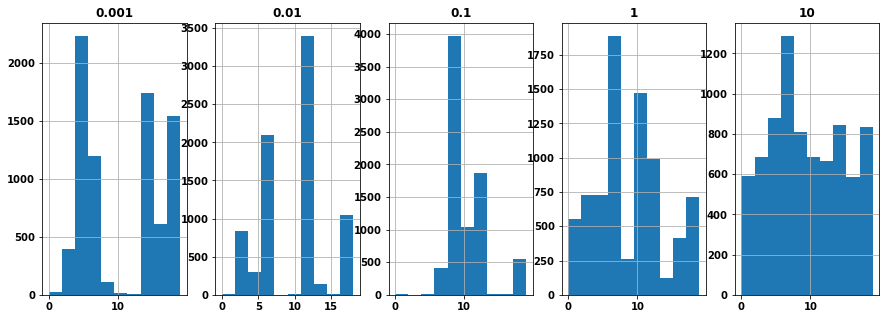

In [5]:

fig, axes = plt.subplots(1,len(tds), figsize=(15,5))

for i, td in enumerate(tds):
    
    td.hist(ax=axes[i])
    axes[i].set_title(str(alphas[i]))


